<a href="https://colab.research.google.com/github/anisafitriani1122/Tugas-Akhir/blob/main/Code_TA_Anisa_Fitriani_Data_Taksiran_Level_Muka_Air_Laut_Minimum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam

In [ ]:
# Import Dataset
link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTVcNCbQ2ki_WfUY16cqZJxmQHgzsjrtRuw8dFcRgrbBImS_dVxtkQZi5mBeNgVOTpMyT-e9xysSz4a/pub?output=xlsx'

# Membaca file Excel dari URL dan memuatnya sebagai DataFrame Pandas
data = pd.read_excel(link)

# Mengambil kolom 'Sea Level' dari DataFrame
sea_level_data = data['Sea Level Error Lower']

# Menampilkan 5 baris pertama dari kolom 'Sea Level'
print("5 Baris Pertama dari Kolom 'Sea Level Error Lower':")
print(sea_level_data.head())

# Menampilkan statistik deskriptif dari kolom 'Sea Level'
print("\nStatistik Deskriptif 'Sea Level':")
print(sea_level_data.describe())

# Mengambil kolom 'Sea Level' dari DataFrame dan mengubahnya menjadi array NumPy
dataset = data['Sea Level Error Lower'].values

# Mengonversi array NumPy ke tipe data float32
dataset = dataset.astype('float32')

5 Baris Pertama dari Kolom 'Sea Level Error Lower':
0   -114.68
1   -117.79
2   -119.16
3   -118.50
4   -116.26
Name: Sea Level Error Lower, dtype: float64

Statistik Deskriptif 'Sea Level':
count    799.000000
mean     -77.772265
std       31.127148
min     -161.300000
25%     -100.160000
50%      -76.100000
75%      -52.550000
max       -1.210000
Name: Sea Level Error Lower, dtype: float64


In [ ]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))  # Menentukan rentang nilai output normalisasi (0 hingga 1)
dataset = np.reshape(dataset, (-1, 1))  # Mengubah array dataset menjadi array 2 dimensi dengan satu kolom
dataset = scaler.fit_transform(dataset)  # Normalisasi data agar nilainya berada dalam rentang 0 hingga 1

# Menampilkan dataset yang telah dinormalisasi
print(dataset)

[[0.29121125]
 [0.27178466]
 [0.263227  ]
 [0.26734966]
 [0.2813418 ]
 [0.30788934]
 [0.33674812]
 [0.34024614]
 [0.3654195 ]
 [0.40171164]
 [0.4593042 ]
 [0.55687433]
 [0.6248361 ]
 [0.6679993 ]
 [0.68998694]
 [0.7026049 ]
 [0.71509784]
 [0.742395  ]
 [0.7653196 ]
 [0.78124815]
 [0.7916173 ]
 [0.8010495 ]
 [0.8154164 ]
 [0.8247861 ]
 [0.8273472 ]
 [0.8203511 ]
 [0.7993005 ]
 [0.77831227]
 [0.753826  ]
 [0.7267163 ]
 [0.700606  ]
 [0.6704979 ]
 [0.64963466]
 [0.6318321 ]
 [0.6141546 ]
 [0.6014118 ]
 [0.5911051 ]
 [0.578737  ]
 [0.57092893]
 [0.5566244 ]
 [0.53969646]
 [0.51908314]
 [0.50527835]
 [0.49653327]
 [0.48666382]
 [0.47585738]
 [0.4550566 ]
 [0.44200146]
 [0.42819673]
 [0.4218253 ]
 [0.41545385]
 [0.41795248]
 [0.42757207]
 [0.44025242]
 [0.4621151 ]
 [0.4850397 ]
 [0.5082767 ]
 [0.535324  ]
 [0.56237125]
 [0.58017373]
 [0.58229756]
 [0.56668127]
 [0.57036674]
 [0.56761825]
 [0.53282535]
 [0.5217691 ]
 [0.52714103]
 [0.52795315]
 [0.5282654 ]
 [0.5354489 ]
 [0.54538083]
 [0.52

In [ ]:
# Bagi Data Menjadi Training dan Testing
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

639 160


In [ ]:
# Fungsi untuk Membuat Dataset untuk LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 6  # Jumlah langkah waktu yang digunakan untuk prediksi
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# Reshape input untuk LSTM (samples, timesteps, features)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
# Hyperparameter yang akan dituning selain look_back
epochs = 50
batch_size = 16
learning_rate = 0.01
units = 128

# Model LSTM
model = Sequential()
model.add(LSTM(units=units, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=units))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile Model dengan Adam Optimizer dan Learning Rate yang bisa diubah
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

#Train Model dengan Epoch dan Batch Size yang bisa diubah
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)

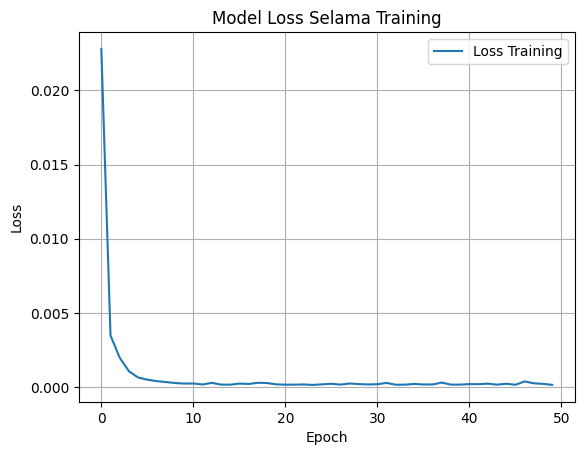

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Loss Training')# Mengambil nilai loss dari history
plt.title('Model Loss Selama Training')  # Judul grafik
plt.xlabel('Epoch')  # Label sumbu X
plt.ylabel('Loss')  # Label sumbu Y
plt.legend()
plt.grid()  # Menambahkan grid untuk memperjelas grafik
plt.show()  # Menampilkan grafik

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


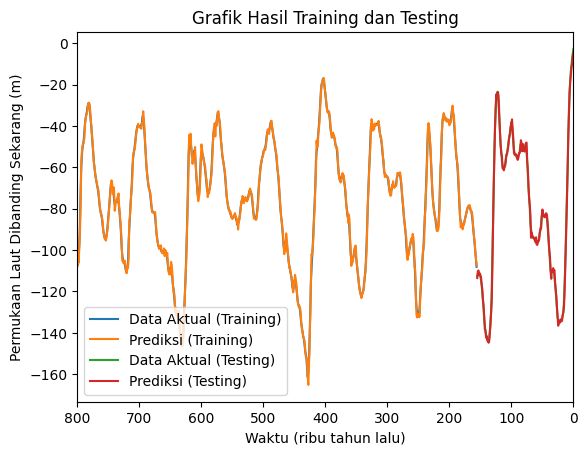

In [ ]:
# Prediksi
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverse Transform untuk mendapatkan nilai asli
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Flatten the arrays to 1-D
trainPredict = trainPredict.flatten()  # Mengubah array hasil prediksi pada data training menjadi array 1-D
testPredict = testPredict.flatten()    # Mengubah array hasil prediksi pada data testing menjadi array 1-D
trainY = trainY.flatten()              # Mengubah array label asli (ground truth) dari data training menjadi array 1-D
testY = testY.flatten()                # Mengubah array label asli (ground truth) dari data testing menjadi array 1-D

# Membuat array waktu dari 800 ke 0
total_length = len(trainY) + len(testY)  # Total panjang data
waktu = np.linspace(800, 0, num=total_length)  # Waktu dari 800 ke 0

# Plot prediksi vs nilai aktual
plt.plot(waktu[:len(trainY)], trainY, label='Data Aktual (Training)')  # Data aktual training
plt.plot(waktu[:len(trainY)], trainPredict, label='Prediksi (Training)')  # Prediksi training
plt.plot(waktu[len(trainY):], testY, label='Data Aktual (Testing)')  # Data aktual testing
plt.plot(waktu[len(trainY):], testPredict, label='Prediksi (Testing)')  # Prediksi testing

# Menambahkan judul dan label
plt.title('Grafik Hasil Training dan Testing')  # Judul grafik
plt.xlabel('Waktu (ribu tahun lalu)')  # Label sumbu X
plt.ylabel('Permukaan Laut Dibanding Sekarang (m)')  # Label sumbu Y

plt.legend()  # Menampilkan legenda
plt.xlim(800, 0)  # Mengatur batas sumbu X dari 800 ke 0
plt.show()  # Menampilkan plot

In [ ]:
# Menghitung RMSE untuk data training
train_rmse = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train RMSE:', train_rmse)

# Calculate RMSE for testing data
test_rmse = math.sqrt(mean_squared_error(testY, testPredict))
print('Test RMSE:', test_rmse)

Train RMSE: 1.762294797860162
Test RMSE: 1.7383467632354455


In [ ]:
# Menghitung R-squared untuk data training
train_r2 = r2_score(trainY, trainPredict)
print('Train R-squared:', train_r2)

# Menghitung R-squared untuk data testing
test_r2 = r2_score(testY, testPredict)
print('Test R-squared:', test_r2)

Train R-squared: 0.9963587207023111
Test R-squared: 0.997759925764761


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    Waktu (ribu tahun lalu)  Permukaan Laut (m)
0                        -1           -1

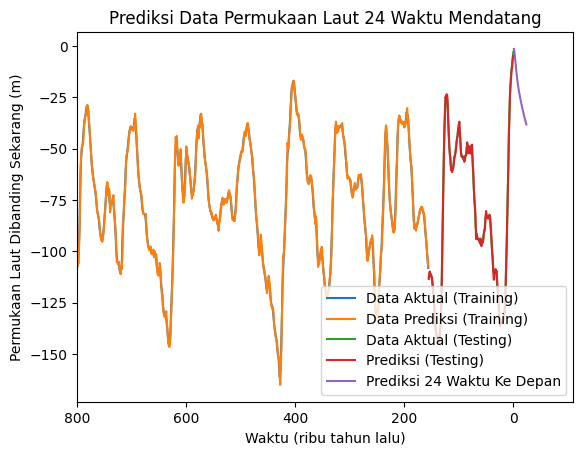

Forecast untuk 24 waktu ke depan: [ -1.348605  -2.906583  -5.252882  -7.948976 -10.723859 -13.367518
 -15.761996 -17.883512 -19.762323 -21.44643  -22.985456 -24.422146
 -25.78806  -27.103096 -28.377892 -29.61686  -30.820719 -31.98857
 -33.119125 -34.211468 -35.265327 -36.28117  -37.259964 -38.20303 ]


In [ ]:
look_back = 6  # Jumlah langkah waktu yang digunakan untuk prediksi
last_data = dataset[-look_back:]  # Ambil data terakhir sebanyak look_back
forecast_data = []

# Forecast untuk 10 waktu ke depan
for _ in range(24):  # Forecast untuk 10 langkah waktu
    input_data = np.reshape(last_data, (1, look_back, 1))
    prediction = model.predict(input_data)
    forecast_data.append(prediction[0][0])
    last_data = np.append(last_data[1:], prediction)  # Update data terakhir dengan prediksi
    last_data = last_data[-look_back:]

# Inverse transform untuk mendapatkan nilai asli
forecast_data = scaler.inverse_transform(np.array(forecast_data).reshape(-1, 1))
forecast_data = forecast_data.flatten()

# Membuat array waktu untuk 10 waktu ke depan dari -1 hingga -25
waktu_prediksi = np.arange(-1, -25, -1)  # Waktu dari -1 ke -10

# Membuat array waktu untuk data aktual dari 800 hingga 0
total_length = len(trainY) + len(testY)  # Total panjang data
waktu_aktual = np.linspace(800, 0, num=total_length)  # Waktu dari 800 ke 0

# Membuat DataFrame untuk hasil prediksi
data_prediksi = pd.DataFrame({
    'Waktu (ribu tahun lalu)': waktu_prediksi,
    'Permukaan Laut (m)': forecast_data
})

# Menampilkan tabel hasil prediksi
print(data_prediksi)

# Plot forecast
plt.plot(waktu_aktual[:len(trainY)], trainY, label='Data Aktual (Training)')  # Data aktual training
plt.plot(waktu_aktual[:len(trainY)], trainPredict, label='Data Prediksi (Training)')  # Prediksi training
plt.plot(waktu_aktual[len(trainY):], testY, label='Data Aktual (Testing)')  # Data aktual testing
plt.plot(waktu_aktual[len(trainY):], testPredict, label='Prediksi (Testing)')  # Prediksi testing
plt.plot(waktu_prediksi, forecast_data, label='Prediksi 24 Waktu Ke Depan', linestyle='-')  # Prediksi 10 waktu ke depan

# Menambahkan judul dan label
plt.title('Prediksi Data Permukaan Laut 24 Waktu Mendatang')
plt.xlabel('Waktu (ribu tahun lalu)')
plt.ylabel('Permukaan Laut Dibanding Sekarang (m)')

plt.legend()  # Menampilkan legenda
plt.xlim(800, -110)  # Mengatur batas sumbu X dari 800 ke -20
plt.show()  # Menampilkan plot

print("Forecast untuk 24 waktu ke depan:", forecast_data)

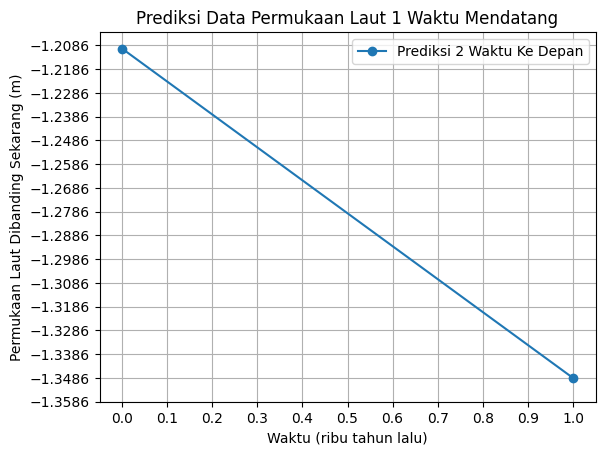

In [ ]:
# Hasil Prediksi 1 Waktu Ke depan
waktu_prediksi = np.arange(0, 2, 1)
forecast_data = [-1.21, -1.348605]  # Example forecast values


plt.plot(waktu_prediksi, forecast_data, label='Prediksi 1 Waktu Ke Depan', marker='o')

# Menambahkan judul dan label
plt.title('Prediksi Data Permukaan Laut 1 Waktu Mendatang')
plt.xlabel('Waktu (ribu tahun lalu)')
plt.ylabel('Permukaan Laut Dibanding Sekarang (m)')

# Mengatur rentang sumbu Y dengan interval 0.05
y_ticks = np.arange(min(forecast_data) - 0.01, max(forecast_data) + 0.01, 0.01)
plt.yticks(y_ticks)
# Mengatur rentang sumbu X dengan interval 0.1
x_ticks = np.arange(0, 1.1, 0.1)  # Rentang dari 0 hingga 1 dengan interval 0.1
plt.xticks(x_ticks)

plt.legend()  # Menampilkan legenda
plt.grid(True) #adds gridlines
plt.show()  # Menampilkan plot

In [ ]:
#from itertools import product

# Parameter untuk Grid Search
# look_back_list = [3, 6, 12]  # Variasi look_back yang ingin diuji
# epochs_list = [50, 100]
# batch_size_list = [16, 32]
# learning_rate_list = [0.001, 0.01]
# units_list = [64, 128]

# Menyimpan hasil tuning
# results = []

# Iterasi semua kombinasi hyperparameter
# for look_back, epochs, batch_size, learning_rate, units in product(look_back_list, epochs_list, batch_size_list, learning_rate_list, units_list):
    #print(f"Training with: look_back={look_back}, epochs={epochs}, batch_size={batch_size}, learning_rate={learning_rate}, units={units}")

    # Membentuk dataset berdasarkan look_back
    # trainX, trainY = create_dataset(train, look_back)
    # testX, testY = create_dataset(test, look_back)

    # Reshape input untuk LSTM (samples, timesteps, features)
    # trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    # testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    # Buat model
    # model = Sequential()
    # model.add(LSTM(units=units, return_sequences=True, input_shape=(look_back, 1)))
    # model.add(LSTM(units=units))
    # model.add(Dense(1))

    # Compile model
    # optimizer = Adam(learning_rate=learning_rate)
    # model.compile(loss='mean_squared_error', optimizer=optimizer)

    # Train model
    # history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)

    # Prediksi
    # testPredict = model.predict(testX)
    # testPredict = scaler.inverse_transform(testPredict)
    # testY_actual = scaler.inverse_transform([testY])

    # Menghitung RMSE
    # test_rmse = math.sqrt(mean_squared_error(testY_actual.flatten(), testPredict.flatten()))
    # print(f"Test RMSE: {test_rmse}")

    # Simpan hasil
    # results.append({
        # 'look_back': look_back,
        # 'epochs': epochs,
        # 'batch_size': batch_size,
        # 'learning_rate': learning_rate,
        # 'units': units,
        # 'test_rmse': test_rmse
    # })

# Cari kombinasi terbaik
# best_result = min(results, key=lambda x: x['test_rmse'])
# print("Best Hyperparameters:")
# print(best_result)

Training with: look_back=3, epochs=50, batch_size=16, learning_rate=0.001, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Test RMSE: 3.861960484764777
Training with: look_back=3, epochs=50, batch_size=16, learning_rate=0.001, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Test RMSE: 3.0449141225586107
Training with: look_back=3, epochs=50, batch_size=16, learning_rate=0.01, units=64


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Test RMSE: 1.858641491472073
Training with: look_back=3, epochs=50, batch_size=16, learning_rate=0.01, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Test RMSE: 2.6412022557182304
Training with: look_back=3, epochs=50, batch_size=32, learning_rate=0.001, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Test RMSE: 9.385768826934513
Training with: look_back=3, epochs=50, batch_size=32, learning_rate=0.001, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Test RMSE: 7.622255461923554
Training with: look_back=3, epochs=50, batch_size=32, learning_rate=0.01, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Test RMSE: 2.0171982915491746
Training with: look_back=3, epochs=50, batch_size=32, learning_rate=0.01, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Test RMSE: 1.7901118807956056
Training with: look_back=3, epochs=100, batch_size=16, learning_rate=0.001, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Test RMSE: 2.018249425267405
Training with: look_back=3, epochs=100, batch_size=16, learning_rate=0.001, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
Test RMSE: 1.845267257662278
Training with: look_back=3, epochs=100, batch_size=16, learning_rate=0.01, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Test RMSE: 2.3468954754732616
Training with: look_back=3, epochs=100, batch_size=16, learning_rate=0.01, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Test RMSE: 2.645280136183667
Training with: look_back=3, epochs=100, batch_size=32, learning_rate=0.001, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Test RMSE: 3.698797502968351
Training with: look_back=3, epochs=100, batch_size=32, learning_rate=0.001, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Test RMSE: 3.284154197496027
Training with: look_back=3, epochs=100, batch_size=32, learning_rate=0.01, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Test RMSE: 2.950855226285455
Training with: look_back=3, epochs=100, batch_size=32, learning_rate=0.01, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Test RMSE: 1.9807464812569568
Training with: look_back=6, epochs=50, batch_size=16, learning_rate=0.001, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Test RMSE: 3.9770762067358794
Training with: look_back=6, epochs=50, batch_size=16, learning_rate=0.001, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Test RMSE: 2.966825015601476
Training with: look_back=6, epochs=50, batch_size=16, learning_rate=0.01, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Test RMSE: 3.5701500942832882
Training with: look_back=6, epochs=50, batch_size=16, learning_rate=0.01, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Test RMSE: 1.692224405513201
Training with: look_back=6, epochs=50, batch_size=32, learning_rate=0.001, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Test RMSE: 6.707572025859142
Training with: look_back=6, epochs=50, batch_size=32, learning_rate=0.001, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Test RMSE: 5.649404783552798
Training with: look_back=6, epochs=50, batch_size=32, learning_rate=0.01, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Test RMSE: 1.9619905614720219
Training with: look_back=6, epochs=50, batch_size=32, learning_rate=0.01, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Test RMSE: 1.9555398659103849
Training with: look_back=6, epochs=100, batch_size=16, learning_rate=0.001, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Test RMSE: 1.9826344593483085
Training with: look_back=6, epochs=100, batch_size=16, learning_rate=0.001, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
Test RMSE: 1.8346308501017432
Training with: look_back=6, epochs=100, batch_size=16, learning_rate=0.01, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Test RMSE: 1.8870917195547579
Training with: look_back=6, epochs=100, batch_size=16, learning_rate=0.01, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Test RMSE: 1.9940132609669978
Training with: look_back=6, epochs=100, batch_size=32, learning_rate=0.001, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Test RMSE: 3.688323260772583
Training with: look_back=6, epochs=100, batch_size=32, learning_rate=0.001, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Test RMSE: 2.6572236275016943
Training with: look_back=6, epochs=100, batch_size=32, learning_rate=0.01, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Test RMSE: 2.484681987850636
Training with: look_back=6, epochs=100, batch_size=32, learning_rate=0.01, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Test RMSE: 2.188888653687828
Training with: look_back=12, epochs=50, batch_size=16, learning_rate=0.001, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Test RMSE: 2.9579271599689574
Training with: look_back=12, epochs=50, batch_size=16, learning_rate=0.001, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Test RMSE: 2.344997917572138
Training with: look_back=12, epochs=50, batch_size=16, learning_rate=0.01, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Test RMSE: 2.0597379082881404
Training with: look_back=12, epochs=50, batch_size=16, learning_rate=0.01, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step
Test RMSE: 2.931316319904898
Training with: look_back=12, epochs=50, batch_size=32, learning_rate=0.001, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Test RMSE: 4.311977981603676
Training with: look_back=12, epochs=50, batch_size=32, learning_rate=0.001, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Test RMSE: 3.8014032840805063
Training with: look_back=12, epochs=50, batch_size=32, learning_rate=0.01, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Test RMSE: 2.2570344404523874
Training with: look_back=12, epochs=50, batch_size=32, learning_rate=0.01, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Test RMSE: 1.7908116182788465
Training with: look_back=12, epochs=100, batch_size=16, learning_rate=0.001, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Test RMSE: 2.0135363739501804
Training with: look_back=12, epochs=100, batch_size=16, learning_rate=0.001, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Test RMSE: 1.7764441164089066
Training with: look_back=12, epochs=100, batch_size=16, learning_rate=0.01, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Test RMSE: 2.187700546532277
Training with: look_back=12, epochs=100, batch_size=16, learning_rate=0.01, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Test RMSE: 1.864631061177006
Training with: look_back=12, epochs=100, batch_size=32, learning_rate=0.001, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Test RMSE: 2.4549328364716527
Training with: look_back=12, epochs=100, batch_size=32, learning_rate=0.001, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Test RMSE: 2.289501843820415
Training with: look_back=12, epochs=100, batch_size=32, learning_rate=0.01, units=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Test RMSE: 1.708807422118995
Training with: look_back=12, epochs=100, batch_size=32, learning_rate=0.01, units=128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Test RMSE: 1.7309082095516597
Best Hyperparameters:
{'look_back': 6, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.01, 'units': 128, 'test_rmse': 1.692224405513201}
